In [115]:
import pandas as pd
import numpy as np
import yfinance as yf
import arch
from arch.unitroot import ADF
from arch import arch_model
import matplotlib.pyplot as plt
import datetime

In [97]:
seel = yf.download(tickers="SEEL", period="7d", interval="1m")
zyne = yf.download(tickers="ZYNE", period="7d", interval="1m")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [113]:
seel_adf = ADF(seel["Close"])
print(seel_adf.summary().as_text())

   Augmented Dickey-Fuller Results   
Test Statistic                 -1.139
P-value                         0.699
Lags                               25
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [99]:
zyne_adf = ADF(zyne["Close"])
print(zyne_adf.summary().as_text())

   Augmented Dickey-Fuller Results   
Test Statistic                 -1.950
P-value                         0.309
Lags                                1
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [50]:
zyne_returns = 100 * (zyne["Close"].pct_change().dropna())
zyne_arch = arch_model(zyne_returns, dist="skewt")
zyne_res = zyne_arch.fit()
print(zyne_res.summary())

Iteration:      1,   Func. Count:      8,   Neg. LLF: 412.25060912046354
Iteration:      2,   Func. Count:     18,   Neg. LLF: 412.2152827223017
Iteration:      3,   Func. Count:     29,   Neg. LLF: 412.1765534570088
Iteration:      4,   Func. Count:     39,   Neg. LLF: 412.10377959838297
Iteration:      5,   Func. Count:     48,   Neg. LLF: 412.06137308880886
Iteration:      6,   Func. Count:     57,   Neg. LLF: 412.0037286793126
Iteration:      7,   Func. Count:     67,   Neg. LLF: 411.97997038753874
Iteration:      8,   Func. Count:     76,   Neg. LLF: 411.9685836920337
Iteration:      9,   Func. Count:     84,   Neg. LLF: 411.93271902598485
Iteration:     10,   Func. Count:     92,   Neg. LLF: 411.9145852056912
Iteration:     11,   Func. Count:    100,   Neg. LLF: 411.9048739350483
Iteration:     12,   Func. Count:    108,   Neg. LLF: 411.9045583172682
Iteration:     13,   Func. Count:    116,   Neg. LLF: 411.90455127888055
Optimization terminated successfully.    (Exit mode 0)
   

In [91]:
zyne[-117:]

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2022-04-14 09:30:00-04:00,1.7800,1.7800,1.7700,1.7700,1.7700,3267
2022-04-14 09:36:00-04:00,1.7600,1.7700,1.7600,1.7600,1.7600,7380
2022-04-14 09:37:00-04:00,1.7600,1.7600,1.7500,1.7500,1.7500,2123
2022-04-14 09:38:00-04:00,1.7450,1.7500,1.7436,1.7436,1.7436,900
2022-04-14 09:39:00-04:00,1.7500,1.7500,1.7500,1.7500,1.7500,1300
...,...,...,...,...,...,...
2022-04-14 15:56:00-04:00,1.7210,1.7210,1.7200,1.7200,1.7200,910
2022-04-14 15:57:00-04:00,1.7285,1.7285,1.7285,1.7285,1.7285,158
2022-04-14 15:58:00-04:00,1.7200,1.7250,1.7200,1.7250,1.7250,1541


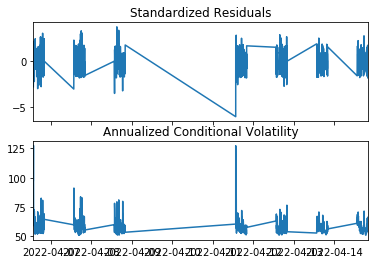

In [93]:
fig = zyne_res.plot(scale=252*120)

In [64]:
zyne_forecasts = zyne_res.forecast(reindex=False)
print(zyne_forecasts.mean.iloc[-3:])
print(zyne_forecasts.residual_variance.iloc[-3:])
print(zyne_forecasts.variance.iloc[-3:])

                                h.1
Datetime                           
2022-04-14 16:00:00-04:00 -0.009247
                                h.1
Datetime                           
2022-04-14 16:00:00-04:00  0.136057
                                h.1
Datetime                           
2022-04-14 16:00:00-04:00  0.136057


In [106]:
zyne_forecasts.variance["h.1"][0]

0.1360568071383528

In [65]:
np.sqrt(0.136057)

0.3688590516715023

In [129]:
def next_min_bound(ticker, st_devs):
    today = datetime.datetime.now()
    four = (today - datetime.timedelta(days = 28)).date().strftime("%Y-%m-%d")
    three = (today - datetime.timedelta(days = 21)).date().strftime("%Y-%m-%d")
    two = (today - datetime.timedelta(days = 14)).date().strftime("%Y-%m-%d")
    one = (today - datetime.timedelta(days = 7)).date().strftime("%Y-%m-%d")
    t43 = yf.download(tickers=ticker, start=four, end=three, interval="1m")
    t32 = yf.download(tickers=ticker, start=three, end=two, interval="1m")
    t21 = yf.download(tickers=ticker, start=two, end=one, interval="1m")
    t10 = yf.download(tickers=ticker, period="7d", interval="1m")
    ticker = pd.concat([t43, t32, t21, t10])
    adf = ADF(ticker["Close"])
    print(adf.summary().as_text())
    returns = 100 * (ticker["Close"].pct_change().dropna())
    arch = arch_model(returns, dist="skewt")
    result = arch.fit()
    print(result.summary())
    var = result.forecast(reindex=False).variance["h.1"][0]
    return np.sqrt(var)*st_devs

In [130]:
next_min_bound("ZYNE", 1)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
   Augmented Dickey-Fuller Results   
Test Statistic                 -0.509
P-value                         0.890
Lags                                7
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
Iteration:      1,   Func. Count:      8,   Neg. LLF: 1138.042993353717
Iteration:      2,   Func. Count:     22,   Neg. LLF: 1137.401740036748
Iteration:      3,   Func. Count:     32,   Neg. LLF: 1112.549144281134
Iteration:      4,   Func. Count:     41,   Neg. LLF: 1106.0122992857227
Iteration:      5,   Func. Count:     50,   Neg. LLF: 1097.1164816

0.41321495480547443

In [132]:
from statsmodels.tsa.stattools import adfuller
txn_data = yf.download("TXN", start='2021-01-01')
adfuller(txn_data["Close"])

[*********************100%***********************]  1 of 1 completed


(-3.080569259121272,
 0.028024969315715315,
 1,
 322,
 {'1%': -3.4508226600665037,
  '5%': -2.870558121868621,
  '10%': -2.571574731684734},
 1564.214816997626)